Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import math
import pandas as pd
#import ipywidgets
from scipy.optimize import curve_fit
#import plotly.express as px
from numpy import mean, std

#from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, scale_x_continuous, scale_y_continuous
#from plotnine.data import mpg

Import data paths

#### 0 - Select specific columns

In [3]:
def clean_data(datam):
    try:
        datam["delayS"]=datam["delay"]/1000
    except KeyError:
        pass
    datam["pTemporalError"]=datam["perceivedTime"]-datam["target.started"]# Calculate temporalError
    datam["pTemporalErrorMs"]=datam["pTemporalError"]*1000
    try:   
        datam["physicalDelay"]=datam["distractor.started"]-datam["target.started"]
    except KeyError: 
        pass
    datam["physicalDelayMs"]=datam["physicalDelay"]*1000
    datam["rt_total"]=datam["responsePointer.stopped"]-datam["responsePointer.started"]
    #except KeyError:
        #print("already cleaned "+str(datam["date"][0]))
    return datam


#### Find outliers  and predicted perceived time 


In [4]:
xAxisTicks=[-0.300 , -0.233, -0.167, -0.100 , -0.033, 0.033, 0.100 ,0.167, 0.233, 0.300]

#remove outlier reaction times
def remove_outlier_for_time(data):
    rows_to_delete= data[np.abs(data["rTAfterMotionTreshold"])>10].index
    data = data.drop(rows_to_delete)
    mean_tmp, std_tmp=data["rTAfterMotionTreshold"].mean(), data["rTAfterMotionTreshold"].std()
    rows_to_delete_lower = data[data["rTAfterMotionTreshold"]>mean_tmp+3*std_tmp].index
    #data = data.drop(rows_to_delete_lower)
    return data


def outlier_remover(data,variable):
    #mean_tmp, std_tmp=data[variable].median(), data[variable].std()
    
    rows_to_delete= data[np.abs(data[variable])>1].index
    #rows_to_delete_lower = data[data["pTemporalError"]<0.75].index

    #rows_to_delete_upper = data[data["pTemporalError"]>1].index
    data = data.drop(rows_to_delete)
    """
    #data = data.drop(rows_to_delete_upper)
    
    q1, q3= np.percentile(data["pTemporalError"],[5,95])
    iqr = q3 - q1
    mean_tmp, std_tmp=data["pTemporalError"].mean(), data["pTemporalError"].std()

    rows_to_delete_lower = data[data["pTemporalError"]<mean_tmp-2*std_tmp].index
    data = data.drop(rows_to_delete_lower)

    rows_to_delete_upper = data[data["pTemporalError"]>mean_tmp+2*std_tmp].index

    #rows_to_delete_lower = data[data["pTemporalError"]<q1].index
    #rows_to_delete_upper = data[data["pTemporalError"]>q3].index
    
    data = data.drop(rows_to_delete_upper)
    """
    ####
    threshold=2
    # Calculate median absolute deviation (MAD)
    median = np.median(data[variable])
    abs_deviations = np.abs(data[variable] - median)
    mad = np.median(abs_deviations)

    # Define the upper and lower threshold
    upper_threshold = median + threshold * mad
    lower_threshold = median - threshold * mad

    # Remove outliers based on MAD
    mask_lower = data[variable] >= lower_threshold
    mask_upper = data[variable] <= upper_threshold
    data = data[mask_lower & mask_upper]

    
    return data
def clean_na(dfo):
    dfo=dfo[dfo["perceivedTime"].notna()]
    dfo=dfo[dfo["target.started"].notna()]
    dfo=dfo[dfo["pTemporalError"].notna()]
    unique_delays=dfo["delayS"].unique()
    dfo_tmp = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","rtDurationBtwRespMotion"])
    # remove outlier on time
    dfo=remove_outlier_for_time(dfo)
    if len(unique_delays)>8:
        for i in unique_delays:
            dfo_tmp_0=outlier_remover(dfo[dfo["delayS"]==i],"pTemporalError")
            dfo_tmp = pd.concat([dfo_tmp, dfo_tmp_0], ignore_index=True)
            #dfo=remove_outlier_for_time(dfo[dfo["delayS"]==i])

        dfo=dfo_tmp
    else:
        dfo=outlier_remover(dfo,"pTemporalError")
    
    return dfo
def modelPerceivedTime(targetTime,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    y=[alpha*(np.sin(math.pi*x))+beta*x for x in targetTime]
    return y
def modelPerceivedTime2(x,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    return alpha*(np.sin(math.pi*x))+beta*x

def predictedPerceivedTime(dfo): 
    #df=df[df["isTrial"]=="trial"]
    # dfo=dfo[dfo["perceivedTime"].notna()]
    # dfo=dfo[dfo["target.started"].notna()]
    # dfo=dfo[dfo["pTemporalError"].notna()]
    # dfo=outlier_remover(dfo,"pTemporalError")
    # fit training
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    ## assign new variables to df
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime # take fitted perceived time to the data
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    dfo["pTemporalErrorFitted"]=dfo["pTemporalErrorFitted"]-mean(dfo["pTemporalErrorFitted"])
    return dfo,params_train,covariance_train

def fitPerceivedTime(dfo):
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    return params_train,covariance_train

def fit_distractor_time_assign(dfo):
    param_train,cov_test=fitPerceivedTime(dfo)
    modelPredictedDistTime = modelPerceivedTime2(dfo["distractor.started"], param_train[0], param_train[1])
    dfo["correctedDistractorTime"]=modelPredictedDistTime
    dfo["correctedDelay"]=dfo["correctedDistractorTime"]-dfo["predictedPerceivedTime"]
    # for delays below 0 set delay=delay+0.033
    dfo.loc[dfo["correctedDelay"]<0,"correctedDelay"]=dfo.loc[dfo["correctedDelay"]<0,"correctedDelay"]+0.033
    # for delays above 0 set delay=delay-0.033
    dfo.loc[dfo["correctedDelay"]>0,"correctedDelay"]=dfo.loc[dfo["correctedDelay"]>0,"correctedDelay"]-0.033
    return dfo

def fit_assign(dfo):
    #dfo=clean_na(dfo)
    param_train,cov_test=fitPerceivedTime(dfo)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], param_train[0], param_train[1])
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    #dfo["pTemporalErrorFitted"]=dfo["pTemporalErrorFitted"]-mean(dfo["pTemporalErrorFitted"])

    return dfo


# Gather overerall data for analysis

In [5]:
#os.chdir("D:/analysis/")
os.listdir()
import glob
os.listdir("C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/good_data")
# specifying the path to csv files
path = "C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/good_data"
os.chdir(path) # changes the directory
# csv files in the path
files = glob.glob("*.csv")  # returns list


# create a blank dataframe with column names
datas = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","rtDurationBtwRespMotion",
                #"predictedPerceivedTime","pTemporalErrorFitted","correctedDistractorTime","correctedDelay",
                "subjID"])
datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","rtDurationBtwRespMotion"])

data_paths=[]
for i in range(1,15):
    participant_files = glob.glob("p"+str(i)+"_*")
    data_paths.append(participant_files)
# file_paths=[i.split('/')[-1] for i in files]
# file_path_nums=[int(i.split('_')[0][1:])-1 for i in file_paths]
files = glob.glob("*.csv")
subjID=1

for data_participants in data_paths:
    datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","rtDurationBtwRespMotion"])
    for data in data_participants:
        df_tmp=pd.read_csv(data)
        try:
            df_tmp=clean_data(df_tmp)
            # select only the relevant columns
            df_tmp=df_tmp[["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
                "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","rtDurationBtwRespMotion"]]
            # row bind the dataframes
            datas_participant = pd.concat([datas_participant, df_tmp], ignore_index=True)
        except KeyError:
            print("already cleaned "+str(df_tmp["date"][0]))
    # slice the data to get only the trials wiah met and unmet congruency
    datas_test=datas_participant[datas_participant["isTrial"]=="trial"]
    datas_training=datas_participant[datas_participant["isTrial"]=="testSingleStim"]

    datas_test_met=datas_test[datas_test["congruency"]=="met"]
    datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
    datas_test_base=datas_test[datas_test["congruency"]=="none"]
    datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

    datas_training=clean_na(datas_training)
    datas_test_expected=clean_na(datas_test_expected)
    datas_test_base=clean_na(datas_test_base)


    datas_participant=pd.concat([datas_training,datas_test_expected,datas_test_base],ignore_index=True)
    datas_participant["subjID"]=subjID
    subjID+=1
    datas = pd.concat([datas, datas_participant], ignore_index=True)


# slice the data to get only the trials wiah met and unmet congruency
datas_test=datas[datas["isTrial"]=="trial"]
# datas_test=datas_test[datas_test["perceivedTime"].notna()]
# datas_test=datas_test[datas_test["target.started"].notna()]
# datas_test=datas_test[datas_test["pTemporalError"].notna()]
datas_training=datas[datas["isTrial"]=="testSingleStim"]

datas_test_met=datas_test[datas_test["congruency"]=="met"]
datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
datas_test_base=datas_test[datas_test["congruency"]=="none"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

# datas_training=fit_assign(datas_training)
# datas_training["correctedDistractorTime"]=datas_training["target.started"]
# datas_training["correctedDelay"]=datas_training["physicalDelay"]

# datas_test_expected=fit_assign(datas_test_expected)
# datas_test_expected=fit_distractor_time_assign(datas_test_expected)
# datas_test_base=fit_assign(datas_test_base)
# datas_test_base=fit_distractor_time_assign(datas_test_base)

########## fit the data ############
datas_training=fit_assign(datas_training)
datas_training["correctedDistractorTime"]=datas_training["target.started"]
datas_training["correctedDelay"]=datas_training["physicalDelay"]

datas_test_expected=fit_assign(datas_test_expected)
datas_test_expected=fit_distractor_time_assign(datas_test_expected)
datas_test_base=fit_assign(datas_test_base)
datas_test_base=fit_distractor_time_assign(datas_test_base)
########## fit the data ############

datas_test_met=datas_test_expected[datas_test_expected["congruency"]=="met"]
datas_test_unmet=datas_test_expected[datas_test_expected["congruency"]=="unmet"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)


datas=pd.concat([datas_training,datas_test_base,datas_test_expected],ignore_index=True)
import warnings
warnings.filterwarnings('ignore')

C:\Users\omeru\AppData\Local\Temp\ipykernel_21720\1945762370.py:123: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\omeru\AppData\Local\Temp\ipykernel_21720\1945762370.py:124: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\omeru\AppData\Local\Temp\ipykernel_21720\2956270863.py:86: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [6]:
import warnings
warnings.filterwarnings('ignore')
# Get summary statistics
def get_summary_statistics(df_trial,variable="pTemporalErrorFitted"):
    df_summary=df_trial.groupby("congruency").agg({variable:["mean","std","median","sem","count","median"]})
    df_summary.columns=["mean","std","median","sem","count","median"]
    df_summary["congruency"]=df_summary.index
    df_summary["congruency"]=df_summary["congruency"].replace({"met":"Met Expectation","unmet":"Unmet Expectation"})
    return df_summary
df_summary=get_summary_statistics(datas_test_expected)
df_summary


,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,0.003296,0.256203,0.021237,0.003885,4349,0.021237,Met Expectation
unmet,0.014673,0.259955,0.034693,0.007940,1072,0.034693,Unmet Expectation


In [7]:
#get_summary_statistics(datas_test_expected,)
get_summary_statistics(datas_test_expected,"rTAfterMotionTreshold")

,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,1.406694,0.946238,1.083107,0.014348,4349,1.083107,Met Expectation
unmet,1.393485,0.861558,1.125199,0.026314,1072,1.125199,Unmet Expectation


## 0 - Raw Temporal Errors

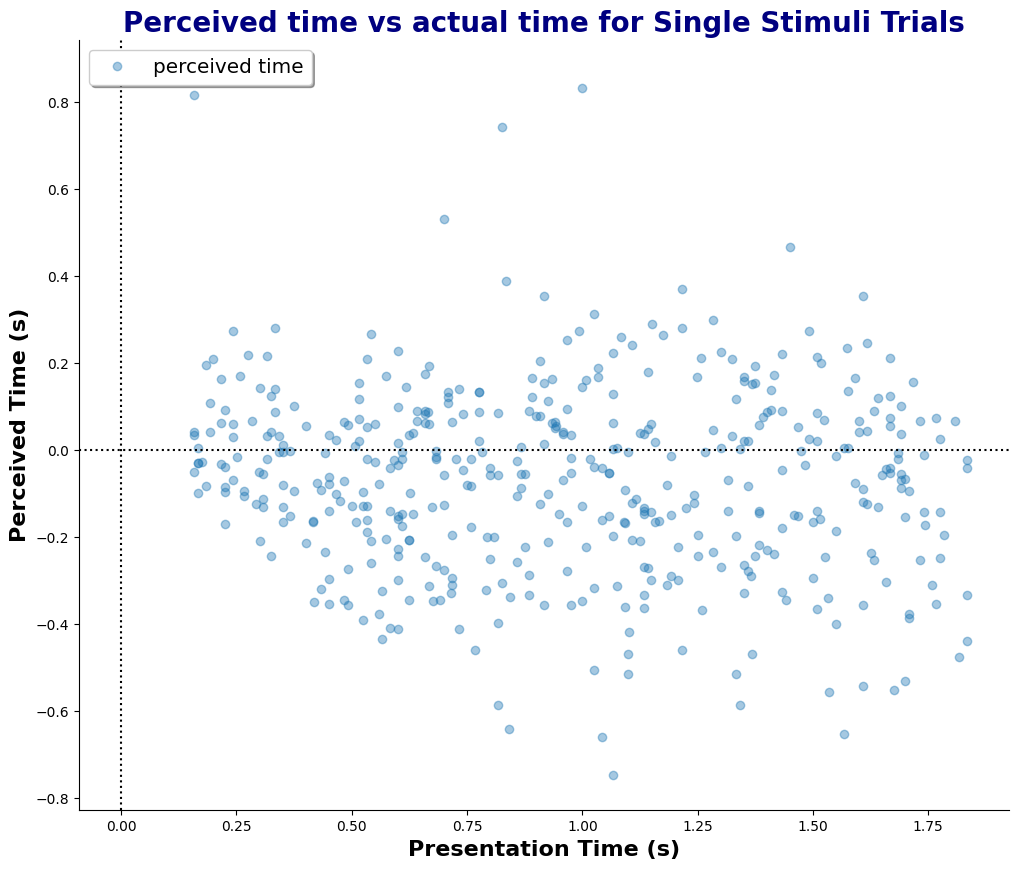

In [8]:
def plot_perceived_actual(df_trial):
    plt.figure(figsize=(12, 10))
    plt.plot(df_trial["target.started"],df_trial["pTemporalError"],'o',label="perceived time",alpha=0.4)
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #plt.axvline(x=2, color='black', linestyle='dotted')
    #plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs actual time for Single Stimuli Trials", fontsize=20, fontweight='bold',c="Navy")
    plt.ylabel("Perceived Time (s)", fontsize=16, fontweight='bold')
    plt.xlabel("Presentation Time (s)", fontsize=16, fontweight='bold')
    # remove axis spines
    sns.despine()
    # add legend
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas_training)

## 1- Perceived time as a function of Presentation time

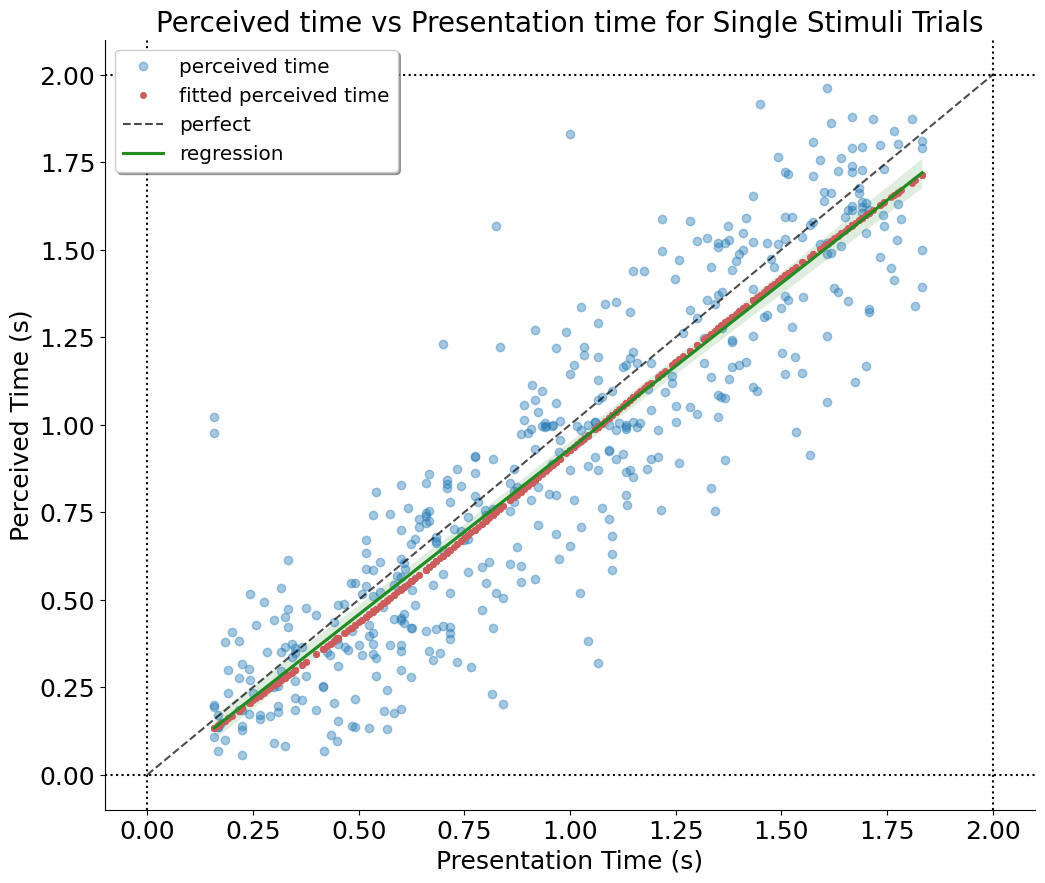

In [9]:
def plot_perceived_actual(df_trial):
    plt.figure(figsize=(12, 10))
    plt.plot(df_trial["target.started"],df_trial["perceivedTime"],'o',label="perceived time",alpha=0.4)
    plt.plot(df_trial["target.started"],df_trial["predictedPerceivedTime"],'ro',label="fitted perceived time",markersize=4,c="IndianRed",alpha=1)
    
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect", c="black",linestyle='dashed',linewidth=1.5,alpha=0.7)
    sns.regplot(df_trial["target.started"],df_trial["perceivedTime"], x_ci="sd",label="regression",scatter=False,color="ForestGreen")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs Presentation time for Single Stimuli Trials", fontsize=20)
    plt.ylabel("Perceived Time (s)", fontsize=18)# fontweight='bold')
    plt.xlabel("Presentation Time (s)", fontsize=18)# fontweight='bold')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # remove axis spines
    sns.despine()
    # add legend
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas_training)
# First of all we need to find the relation between perceived time and actual time on the single stimuli trials.
# We used a sinusoidal model to fit the data and create corrected versions of the target and distractor time for each trial on the actual experimental trials.
# We then used these corrected times to calculate the temporal errors.
# We needed to do this to account for the fact that the perceived time is not linearly related to the actual time.
# We can see this in the plot below where the perceived time is plotted against the actual time for the single stimuli trials.
# Participants tend to underestimate the time of the shorter stimuli and overestimate the time of the longer stimuli.
# This is why we need to correct the times for the actual experimental trials. To get rid of this bias. 


# Create a caption for the figure
txt = '''
Figure 1: Perceived time vs Presentation time for Single Stimuli Trials. Black dotted lines represent the perfect prediction.
Blue dots represent the perceived time for each trial. Red dots represent the fitted perceived time for each trial.
Green line represents the regression line for the fitted perceived time.
'''




## 2.Overall Temporal Error

parameters of model 
[0.20932128 0.55507263]
 standard errors of the parameters 
[0.04636753 0.18808243]


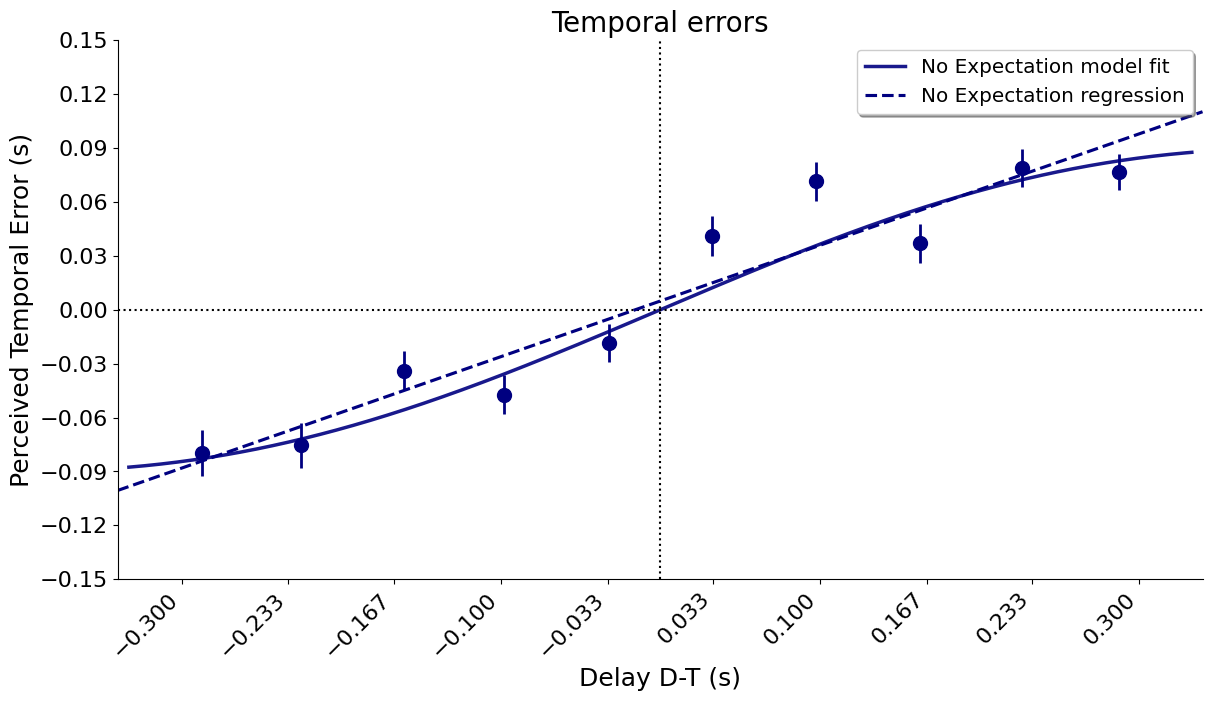

In [10]:
# Get meaans grouped by constant target-distractor delay
def get_medians(data):
    #df=clean_data(data=data_Erva)
    df_medians=data.groupby('delayS').mean()
    df_stdDev=data.groupby("delayS").std()
    #df_medians=data.groupby('subjID','delayS').median()
    #df_stdDev=data.groupby("subjID","delayS").std()
    # a=list(df_medians["delay"].unique())
    # a.sort()
    # df_medians["delayMs"]=a
    # del a
    #medX=df_medians["physicalDelay"]
    medX=df_medians["correctedDelay"]
    medY=df_medians["pTemporalErrorFitted"]
    
    # group the data by delayS and calculate the median and standard error of the median
    df_sem=data.groupby("delayS").sem()
    semY=df_sem["pTemporalErrorFitted"]
    #semY=list[semY]
    return medX, medY, semY
    
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/(sigma**2))+teta for x in delay]
    return modelPerceivedError

def model_time_base(delay,alpha,sigma):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/(sigma**2)) for x in delay]
    return modelPerceivedError

## plot the model
def plot_base_model(medians,df_trial,color):
    if medians==True:      xdata,ydata,semo=get_medians(df_trial)
    #else:        xdata,ydata=df_trial["physicalDelay"],df_trial["pTemporalErrorFitted"]
    else:        xdata,ydata=df_trial["correctedDelay"],df_trial["pTemporalErrorFitted"]
    medianX,mediansY,semo=get_medians(df_trial)

    middleInt=np.linspace(-0.333,0.333,1000)

    # Method 1
    #parameters, covariance = curve_fit(modelPTime, xdata, ydata) # METHOD 1 - 3 parameters
    #fit_k = modelPTime(middleInt, parameters[0],parameters[1],parameters[2]) # METHOD 1 - 3 parameters
    
    
    ## Method 2
    parameters, covariance = curve_fit(model_time_base, xdata, ydata) # METHOD 2 -2 parameters
    fit_k = model_time_base(middleInt, parameters[0],parameters[1])#,parameters[2]) # Method 2 - 2 parameters

    # print the parameters and covariance
    print("parameters of model ")
    print(parameters)
    # calculate the standard errors of the parameters
    perr = np.sqrt(np.diag(covariance))
    print(" standard errors of the parameters ")
    print(perr)

    #plt.figure(figsize=(15, 12))
    # label most occuring congruency
    label=df_trial["congruency"].value_counts().index[0]
    if label=="none":
        label="No Expectation"
    lw=2.5
    if label=="unmet":
        lw=3.5
        
    #if medians==1:
    #plt.plot(medianX, mediansY, 'o',label=str(label)+' data',color=color)
    plt.errorbar(medianX,mediansY, yerr=semo, fmt='o', capsize=3,c=color, 
    # remove error bar top and bottem lines
    elinewidth=2, capthick=0 , markersize=10   )
    # remove error bar caps


    
    plt.plot(middleInt, fit_k, '-', label=str(label)+' model fit',color=color, linewidth=lw,alpha=0.9 )
    
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydata, ci=None,label=str(label)+" regression")
    
    ### Plot by regression
    sns.regplot(xdata,ydata, ci=None,label=str(label)+" regression",scatter=False,color=color, line_kws={'linestyle':'--'} )
    
    plt.title("Temporal errors",fontsize=20,c="Black")
    plt.ylabel("Perceived Temporal Error (s)",fontsize=18)
    plt.xlabel("Delay D-T (s)",fontsize=18)
    ylim=0.15
    plt.ylim(-ylim,ylim)
    plt.yticks(list(np.linspace(-ylim,ylim,11)))
    plt.xticks(xAxisTicks,rotation=45, ha='right', 
    # tickk size
    fontsize=16)
    plt.yticks(fontsize=16)
    # remove axis spines
    sns.despine()
    plt.legend(  shadow=True, fontsize='x-large')
    # legend
    SE = np.sqrt(np.diag(covariance))
    SE_A , SE_B= SE[0], SE[1]
    #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
    #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')
plt.figure(figsize=(14, 7))
#plot_base_model(medians=0,df_trial=datas_test_met,color="IndianRed")
#plot_base_model(medians=0,df_trial=datas_test_unmet,color="ForestGreen")
plot_base_model(medians=0,df_trial=datas_test_base,color="Navy") #description of the figure
# figure description
# Figure 1: Temporal errors for no expectation condition. 
# The data points represent the median temporal error for each delay condition.
# The solid line represent the best fit of the model to the data. The dashed line represent the simple regression line.
# The error bars represent the standard error of the mean.
# The delays are jittered as the delay is taken as physical delay plus corrected as a function of baseline(sinle stimuli) time estiemation absolute error model.

# Figure 2: Temporal errors for expectation condition which shows both met and unmet expectation trials.
# The data points represent the median temporal error for each delay condition.
# The solid line represent the best fit of the model to the data. The dashed line represent the simple regression line.
# The error bars represent the standard error of the mean. Red color represent the met expectation condition and green color represent the unmet expectation condition.
# Green color represent the unmet expectation condition. As you can see the model fits the data better for the met expectation condition.
# When comparing the met and unmet expectation conditions, on the unmet expectation condition when the distractor is presented earlier than expected, perceived temporal error gets lower than the met expectation condition.
# This could be speculated as because the distractor is presented earlier than expected, the distractor is perceived as a target. And on the other hand when the distractor is presented later than expected, perceived temporal error gets higher than the met expectation condition.
# and the reason for that could be explained similarly; since distractor perceived as target and since it is presented later than target, participants tend to perceive the moment of target then actual target presentation time. 

# 3 - Reaction and Response Times

### 3.1 Response Time 

RT total for met data= 0.0164290000102482
RT total for unmet data= 0.05842284999744145
results for response times after motion treshold
T-Statistic: -0.9900143517950579
P-Value: 0.3222219037742655


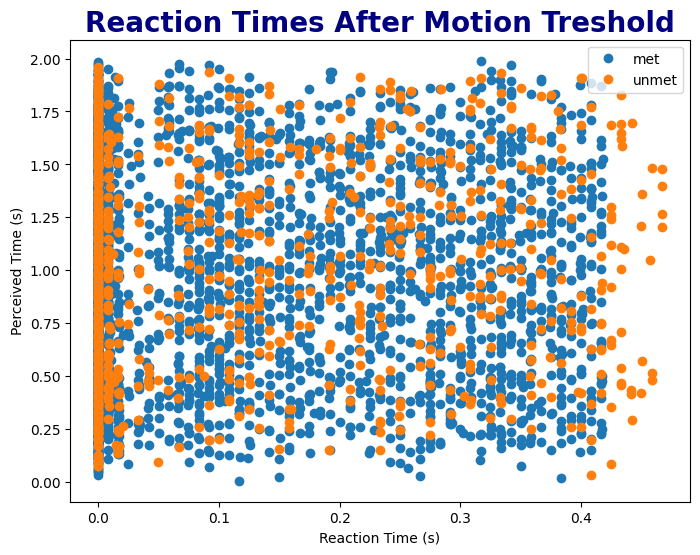

In [132]:

#remove outlier reaction times
def remove_outlier_for_time(data,variable):
    #rows_to_delete= data[np.abs(data[variable])>6].index
    #data = data.drop(rows_to_delete)
    mean_tmp, std_tmp=data[variable].median(), data[variable].std()
    # Calculate median absolute deviation (MAD)
    median = np.median(data[variable])
    abs_deviations = np.abs(data[variable] - median)
    mad = np.median(abs_deviations)
    
    rows_to_delete_lower = data[data[variable]>mean_tmp+3*mad].index
    rows_to_delete_upper = data[data[variable]<mean_tmp-3*mad].index
    data = data.drop(rows_to_delete_lower)
    data = data.drop(rows_to_delete_upper)
    #data=data[data[variable]>0]
    return data

variable="rtUntillMotionTreshold"
# concatanate met and unmet data
#datas_test=pd.concat([datas_test_met,datas_test_unmet])

datas_test_RT=remove_outlier_for_time(datas_test_expected,variable)
# df_test_met_time=datas_test_RT[datas_test_RT["congruency"]=="met"]
# df_test_unmet_time=datas_test_RT[datas_test_RT["congruency"]=="unmet"]

df_test_met_time=remove_outlier_for_time(datas_test_met,variable)
df_test_unmet_time=remove_outlier_for_time(datas_test_unmet,variable)

print("RT total for met data= "+str(np.median(df_test_met_time[variable])))
print("RT total for unmet data= "+str(np.median(df_test_unmet_time[variable])))

plt.figure(figsize=(8, 6))
plt.plot(df_test_met_time[variable],df_test_met_time["perceivedTime"],'o',label="met")
plt.plot(df_test_unmet_time[variable],df_test_unmet_time["perceivedTime"],'o',label="unmet")
plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Perceived Time (s)")
plt.xlabel("Reaction Time (s)")
plt.legend()
#plt.xlim(0,2)
# Perform t-test
t_statistic, p_value = ttest_ind(df_test_met_time["rtDurationBtwRespMotion"], df_test_unmet_time["rtDurationBtwRespMotion"])
print("results for response times after motion treshold")
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# t_statistic, p_value = ttest_ind(df_test_met_time["rtUntillMotionTreshold"], df_test_unmet_time["rtUntillMotionTreshold"])
# print("results for reaction times until motion treshold")
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)
# t_statistic, p_value = ttest_ind(df_test_met_time["rTAfterMotionTreshold"], df_test_unmet_time["rTAfterMotionTreshold"])
# # Print t-statistic and p-value
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)

In [140]:
df_test_met_time["rtUntillMotionTreshold"]

2       0.000000
5       0.366462
6       0.116509
7       0.000000
8       0.283352
          ...   
4344    0.066574
4345    0.016653
4346    0.358532
4347    0.000000
4348    0.000000
Name: rtUntillMotionTreshold, Length: 3463, dtype: float64

mu = 3009.2043816926034
sigma = -0.0001405559036818763
tau = 4.1756207071675505e-05
mu = 2500.2615686431873
sigma = -0.00016845931343483335
tau = 4.20252593159421e-05


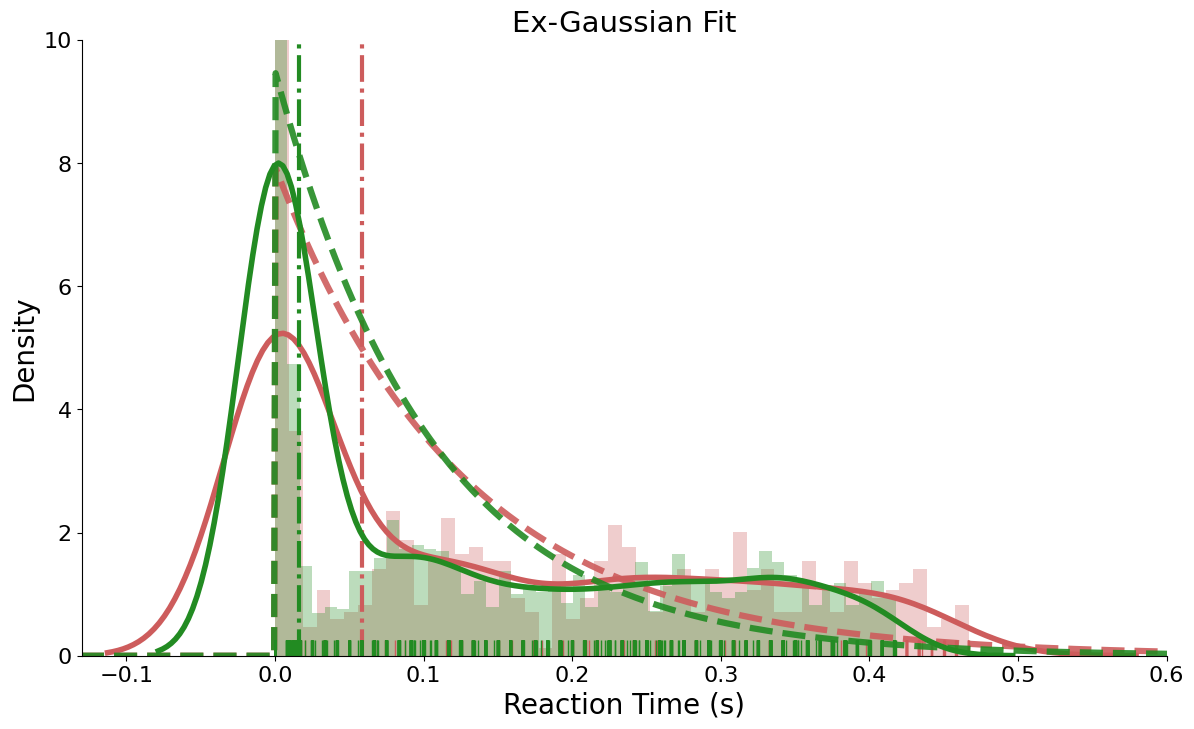

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import exponnorm
# Ex-Gaussian fit
def fit_exgauss(data, coloro, cong):
    if cong=="met":
        alpha=0.2
    else:
        alpha=0.5
    params = exponnorm.fit(data)
    print("mu =", params[0])
    print("sigma =", params[1])
    print("tau =", params[2])
    x = np.linspace(-5, 5, 10000)
    plt.hist(data, bins=50, density=True, color=coloro, alpha=0.3, label=cong+" histogram")
    sns.distplot(data, hist=True, rug=True,color=coloro,
                 hist_kws={'edgecolor': 'black', 'alpha': 0.0},
                 kde_kws={'linewidth': 4,  "label": cong+" density", 
                          # line type
                          "linestyle": "-",
                          "alpha":0.8}
                 #rug_kws={'color': 'black', 'alpha': 0.2},
                 # remove density lines
                 )
                 #kde=False, norm_hist=True)

    plt.plot(x, exponnorm.pdf(x, *params), lw=4.5, label="ex-Gaussian fit " +cong, color=coloro, # no label
             alpha=0.9,
             linestyle='--'            
             )
    # fill area under the curve
    #plt.fill_between(x, exponnorm.pdf(x, *params), color=coloro, alpha=alpha)
    
    # plor vertical line at medians
    plt.axvline(x=np.median(data), color=coloro, linestyle='-.', linewidth=3, label=cong+" median")
    plt.title("Ex-Gaussian Fit", fontsize=21 )
    plt.xlabel("Reaction Time (s)", fontsize=20)
    plt.ylabel("Density", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # legend name is either met or unmet cong
    #plt.legend( fontsize=17, loc="upper right", # larger
    #            frameon=False, # remove frame
                #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.
    #)
    # spine
    sns.despine()
    plt.ylim(0, 10)
    plt.xlim(-0.13, 0.60)
    #plt.show()
    # # Extract the mean parameter from each fitted distribution

    
    
plt.figure(figsize=(14, 8))

#fit_exgauss(data=df_test_met_time["rTAfterMotionTreshold"],coloro="IndianRed",cong="met")
#fit_exgauss(data=df_test_unmet_time["rTAfterMotionTreshold"],coloro="ForestGreen",cong="unmet")
fit_exgauss(data=df_test_unmet_time["rtUntillMotionTreshold"],coloro="IndianRed",cong="unmet")
fit_exgauss(data=df_test_met_time["rtUntillMotionTreshold"],coloro="ForestGreen",cong="met")
## Figure description
# Figure 7: Ex-Gaussian fit for response times after motion threshold for met and unmet conditions. 
# The ex-Gaussian fit is a convolution of a Gaussian and an exponential distribution.

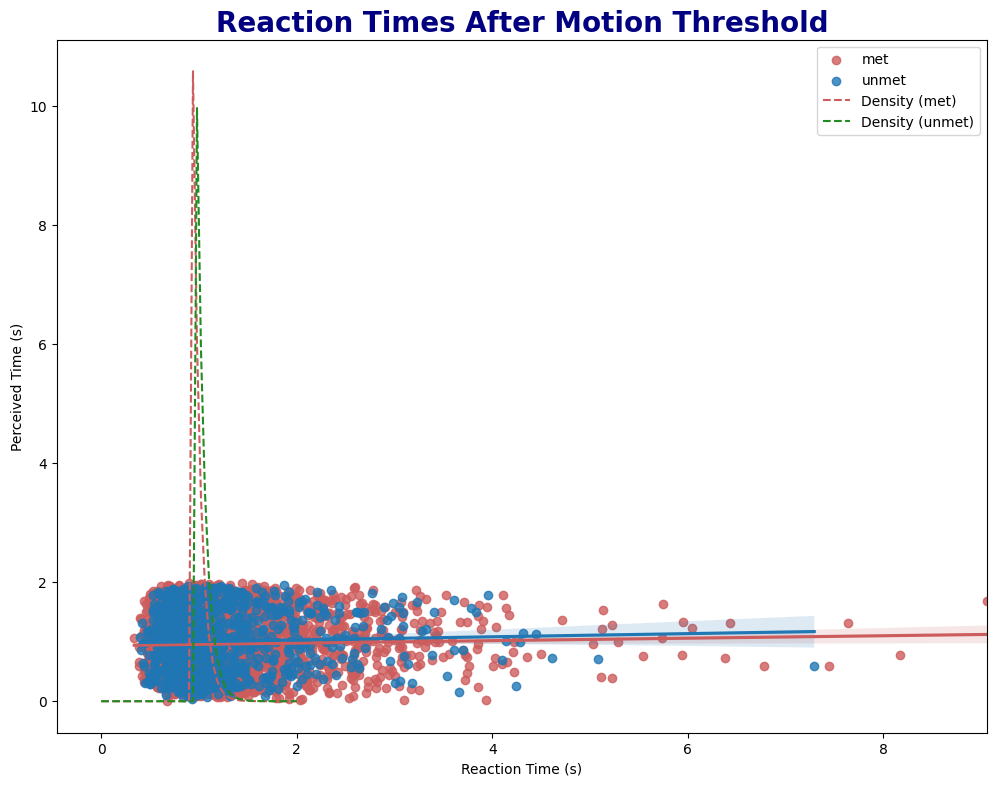

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, norm
from sklearn.mixture import GaussianMixture

# Define the ex-Gaussian distribution function
def exgauss(x, mu, sigma, tau):
    norm_pdf = norm.pdf(x, mu, sigma)
    expon_pdf = expon.pdf(x - mu, scale=tau)
    return norm_pdf * expon_pdf

# Set the number of bins for the density plot
num_bins = 50

# Plot scatter plot with trendlines
plt.figure(figsize=(12, 9))
sns.regplot(x=df_test_met_time["rTAfterMotionTreshold"], y=df_test_met_time["perceivedTime"], label="met", color="indianred")
sns.regplot(x=df_test_unmet_time["rTAfterMotionTreshold"], y=df_test_unmet_time["perceivedTime"], label="unmet")

# Perform ex-Gaussian fitting for met condition
gmm_met = GaussianMixture(n_components=2)
gmm_met.fit(df_test_met_time["rTAfterMotionTreshold"].values.reshape(-1, 1))
mu_met, sigma_met = gmm_met.means_.flatten()
tau_met = gmm_met.covariances_.flatten()[0]

# Perform ex-Gaussian fitting for unmet condition
gmm_unmet = GaussianMixture(n_components=2)
gmm_unmet.fit(df_test_unmet_time["rTAfterMotionTreshold"].values.reshape(-1, 1))
mu_unmet, sigma_unmet = gmm_unmet.means_.flatten()
tau_unmet = gmm_unmet.covariances_.flatten()[0]

# Generate x-values for the density plot
x = np.linspace(0, 2, num_bins)

# Calculate density values using the ex-Gaussian function
density_met = exgauss(x, mu_met, sigma_met, tau_met)
density_unmet = exgauss(x, mu_unmet, sigma_unmet, tau_unmet)

# Normalize the density values
density_met /= np.trapz(density_met, x)
density_unmet /= np.trapz(density_unmet, x)

# Plot density curves
plt.plot(x, density_met, label="Density (met)",color="indianred", linestyle="--")
plt.plot(x, density_unmet, label="Density (unmet)", color="ForestGreen", linestyle="--")

# Set plot title and labels
plt.title("Reaction Times After Motion Threshold", fontsize=20, fontweight='bold', c="Navy")
plt.xlabel("Reaction Time (s)")
plt.ylabel("Perceived Time (s)")

# Add legend and set plot limits
plt.legend()
#plt.xlim(0, 2)

plt.show()


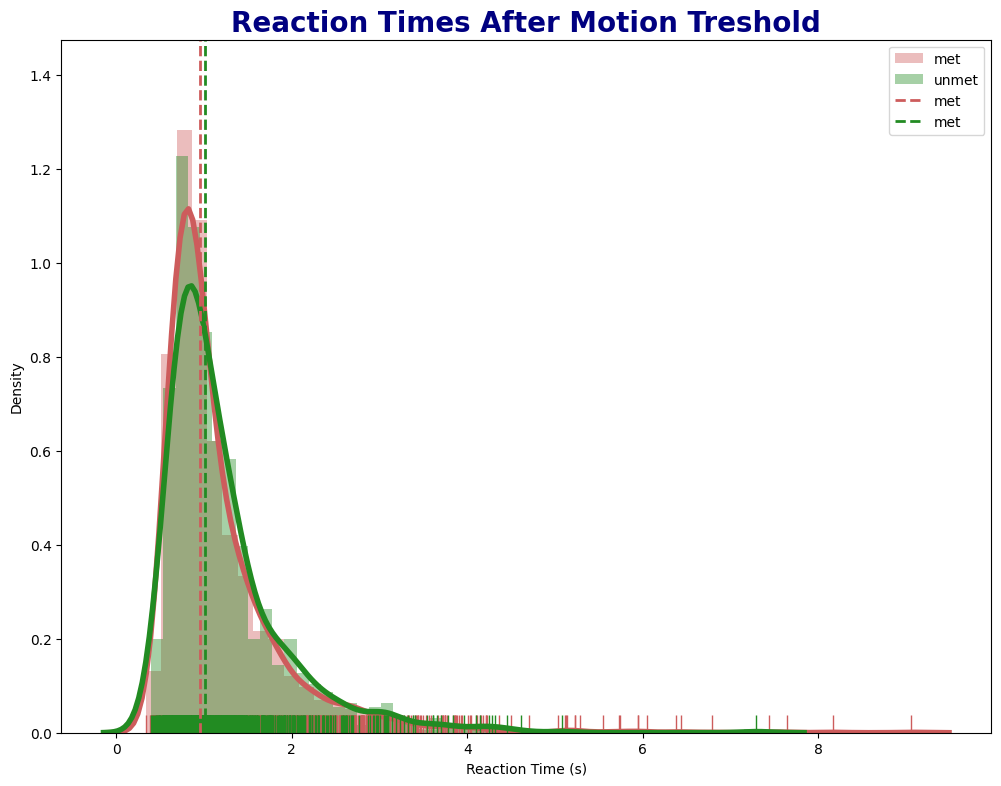

In [128]:
# create density plot for response times
plt.figure(figsize=(12, 9))
sns.distplot(df_test_met_time["rTAfterMotionTreshold"], hist=True, rug=True,label="met",color="IndianRed",             kde_kws={'linewidth': 4})
sns.distplot(df_test_unmet_time["rTAfterMotionTreshold"], hist=True, rug=True,label="unmet",color="ForestGreen",            kde_kws={'linewidth': 4})
    # indicate the mean
plt.axvline(x=np.median(df_test_met_time["rTAfterMotionTreshold"]), color='IndianRed', linestyle='dashed', linewidth=2,label="met")
plt.axvline(x=np.median(df_test_unmet_time["rTAfterMotionTreshold"]), color='ForestGreen', linestyle='dashed', linewidth=2,label="met")

plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Density")
plt.xlabel("Reaction Time (s)")
plt.legend()



In [15]:
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(df_test_met_time["rTAfterMotionTreshold"], df_test_unmet_time["rTAfterMotionTreshold"])
#t_statistic, p_value = ttest_ind(df_test_met_time["rtUntillMotionTreshold"], df_test_unmet_time["rtUntillMotionTreshold"])
# Print t-statistic and p-value
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: -2.2816742411829467
P-Value: 0.022553973491086385


### 3.2 Reaction Times - rtUntillMotionTreshold

RT total for met data= 0.0164290000102482
RT total for unmet data= 0.05842284999744145


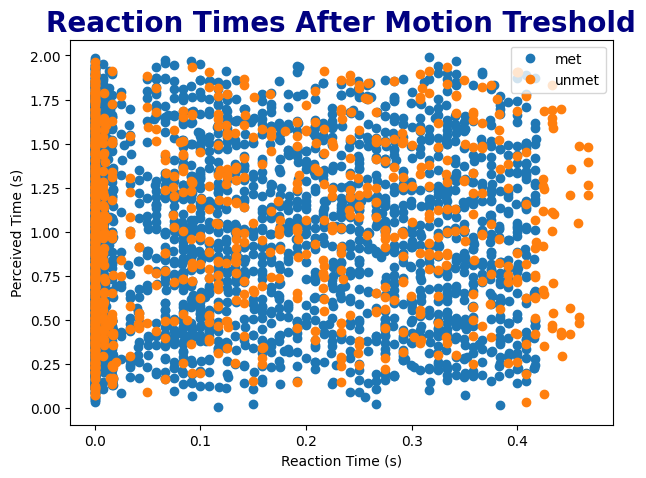

In [129]:
print("RT total for met data= "+str(np.median(df_test_met_time["rtUntillMotionTreshold"])))
print("RT total for unmet data= "+str(np.median(df_test_unmet_time["rtUntillMotionTreshold"])))
plt.figure(figsize=(7, 5))
plt.plot(df_test_met_time["rtUntillMotionTreshold"],df_test_met_time["perceivedTime"],'o',label="met")
plt.plot(df_test_unmet_time["rtUntillMotionTreshold"],df_test_unmet_time["perceivedTime"],'o',label="unmet")
plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Perceived Time (s)")
plt.xlabel("Reaction Time (s)")
plt.legend()
#plt.xlim(0,2)

# 3.2.2 Significance test on Response Times

In [ ]:
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(df_test_met_time["rTAfterMotionTreshold"], df_test_unmet_time["rTAfterMotionTreshold"])
#t_statistic, p_value = ttest_ind(df_test_met_time["rtUntillMotionTreshold"], df_test_unmet_time["rtUntillMotionTreshold"])

# Print t-statistic and p-value
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: -0.486175824616531
P-Value: 0.626862806071899


# 4 - Significance Test on Temporal Error

In [ ]:
from scipy import stats
import numpy as np

delay_points = datas_test_expected["delayS"].unique()

for delay in delay_points:
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    min_len = min(len(met_data), len(unmet_data))
    met_data = met_data[:min_len]
    unmet_data = unmet_data[:min_len]
    
    t_statistic, p_value = stats.ttest_rel(met_data, unmet_data)
    
    print(f"Delay: {delay}")
    print(f"Met Mean: {np.mean(met_data)}")
    print(f"Unmet Mean: {np.mean(unmet_data)}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print("")



Delay: 0.233
Met Mean: 0.11780404597621423
Unmet Mean: 0.04395261379394494
T-statistic: 2.604458408088797
P-value: 0.010839950274847375

Delay: 0.1
Met Mean: 0.05741512973166266
Unmet Mean: 0.033237110808750976
T-statistic: 0.6933943147824638
P-value: 0.48952367378440553

Delay: -0.233
Met Mean: -0.029454872413928468
Unmet Mean: -0.11888529654905217
T-statistic: 2.7276975648346826
P-value: 0.0077306244803482735

Delay: -0.3
Met Mean: -0.05473297592587368
Unmet Mean: -0.11342956018566787
T-statistic: 1.7647734443956145
P-value: 0.0804551628699481

Delay: 0.167
Met Mean: 0.040224615179164806
Unmet Mean: 0.029231128570893265
T-statistic: 0.3135228892978753
P-value: 0.7544718270199444

Delay: -0.033
Met Mean: 0.0028232277106209854
Unmet Mean: 0.0002204783137650272
T-statistic: 0.07402361368419048
P-value: 0.9411718746751687

Delay: 0.033
Met Mean: -0.016781479999766476
Unmet Mean: 0.04425497578598799
T-statistic: -2.2837386628360155
P-value: 0.024638611454376454

Delay: -0.167
Met Mean: -0

In [ ]:

# Perform independent samples t-test for each delay
for delay in delay_points:
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalErrorFitted"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalErrorFitted"]
    
    t_statistic, p_value = stats.ttest_ind(met_data, unmet_data)
    
    print(f"Delay: {delay}")
    print(f"Met Mean: {np.mean(met_data)}")
    print(f"Unmet Mean: {np.mean(unmet_data)}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print("")
    

NameError: name 'delay_points' is not defined

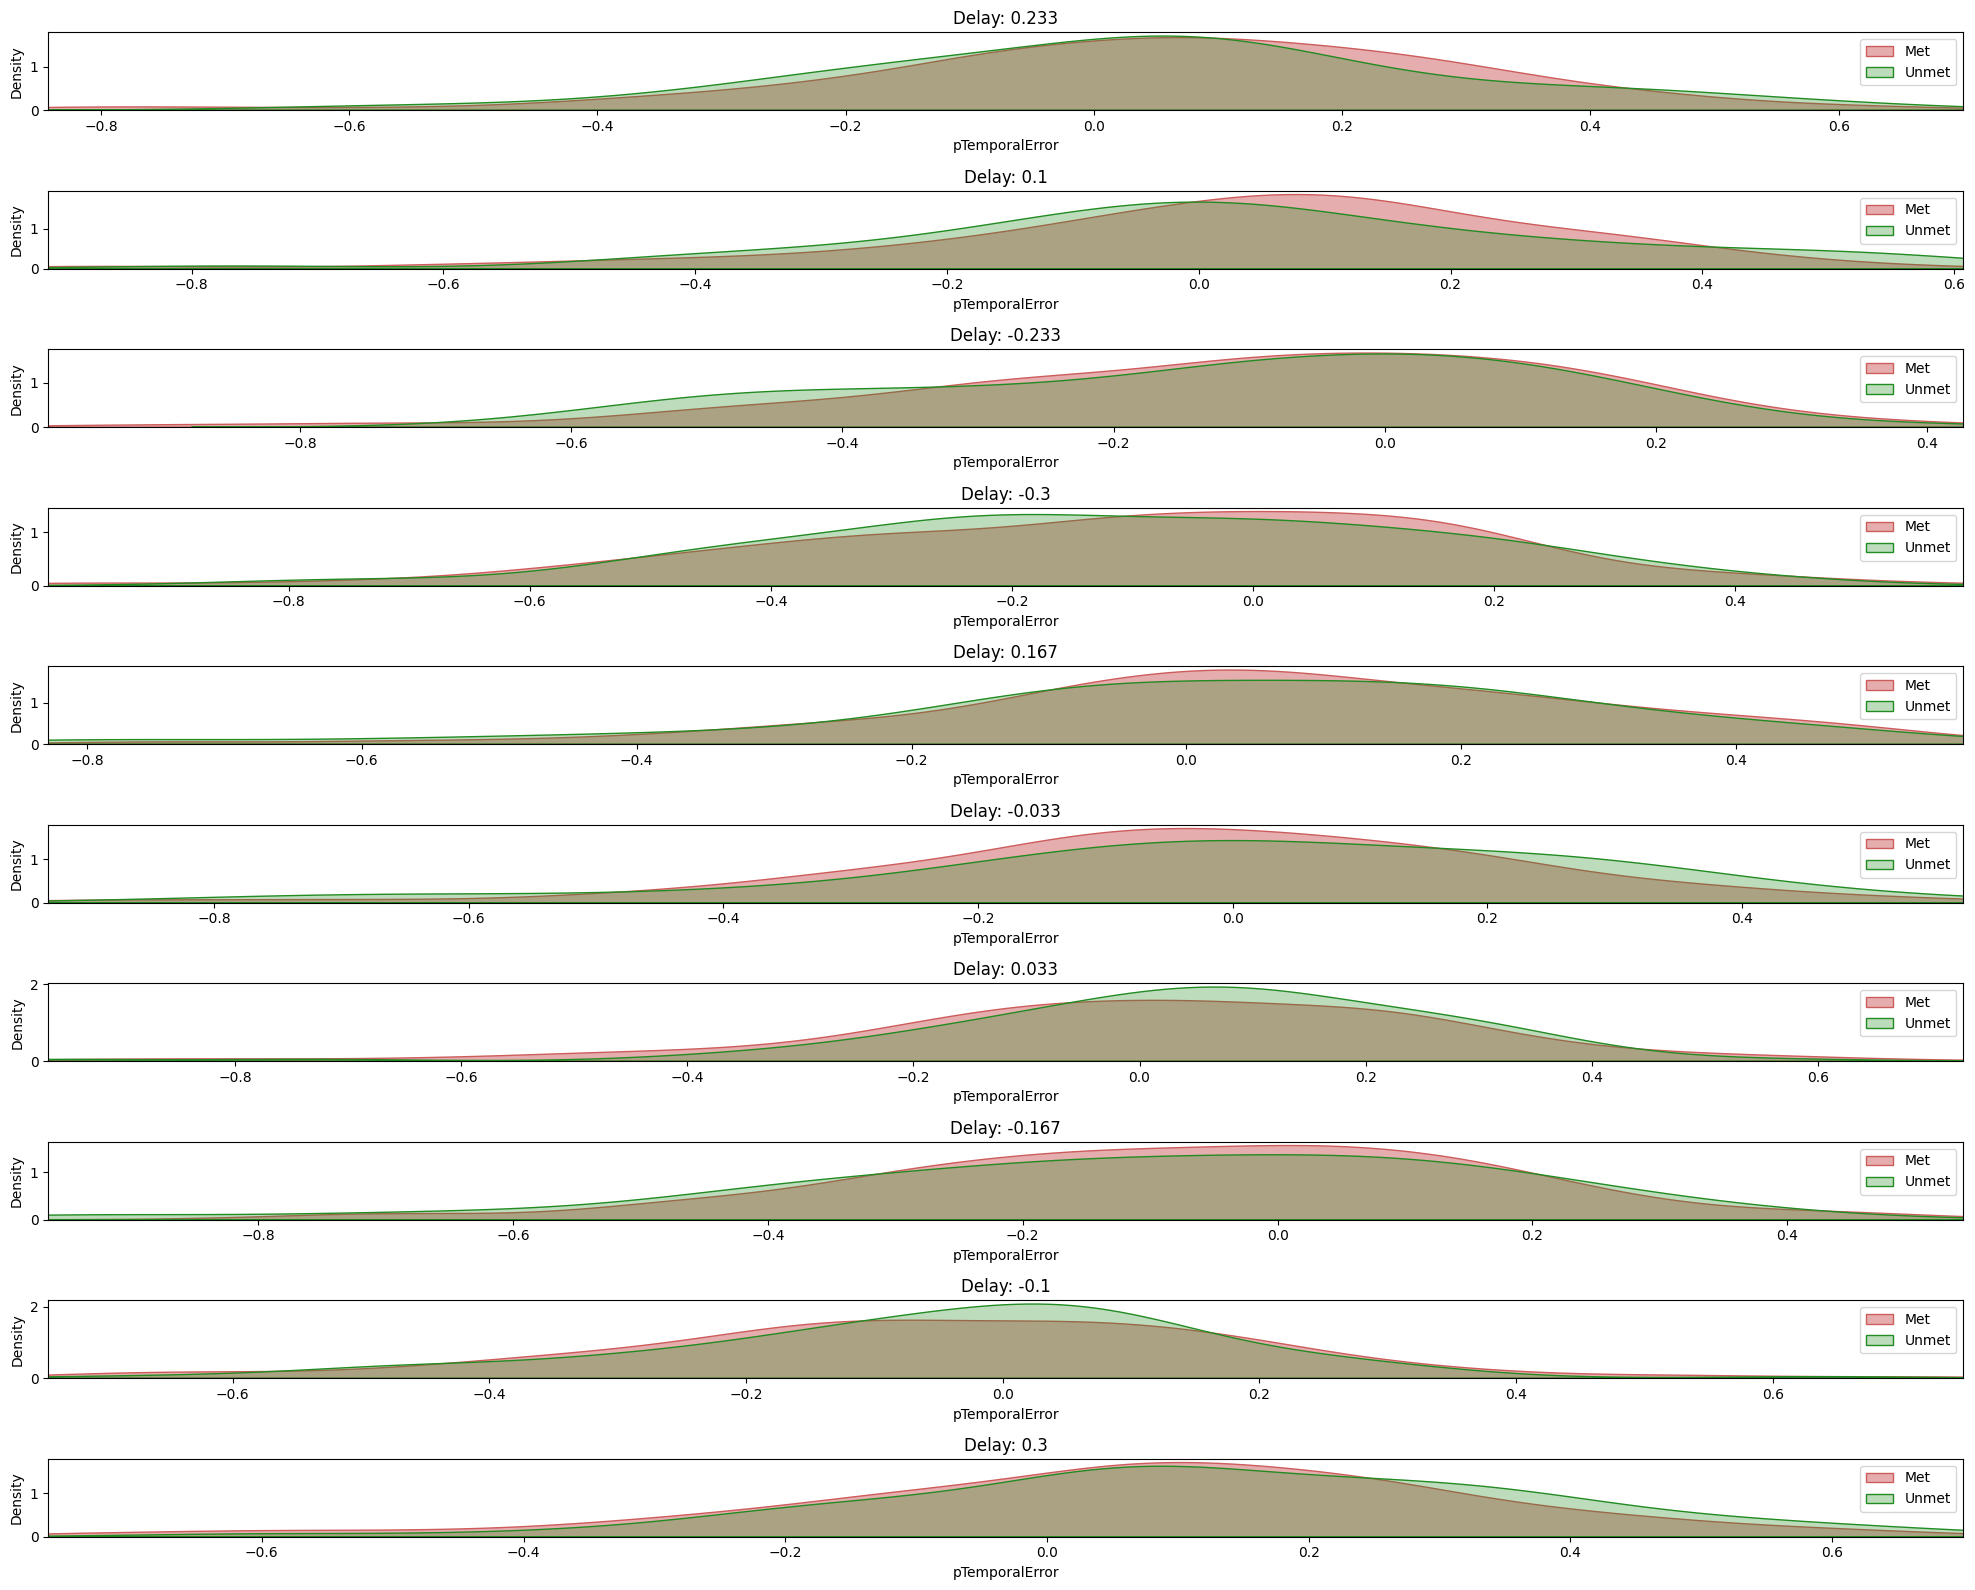

In [ ]:
import matplotlib.pyplot as plt

# Create a subplot grid based on the number of delay points
num_delays = len(delay_points)
fig, axes = plt.subplots(num_delays, 1, figsize=(20, 16))

# Iterate through each delay point
for i, delay in enumerate(delay_points):
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    # Select the appropriate subplot for the current delay
    ax = axes[i] if num_delays > 1 else axes
    
    # Plot the density distributions for "met" and "unmet" conditions
    #ax.hist(met_data, density=True, bins=20, alpha=0.5, label="Met")
    # also plot density line
    sns.kdeplot(met_data, shade=True, color="indianred", ax=ax, label="Met", alpha=0.5)
    #ax.hist(unmet_data, density=True, bins=20, alpha=0.5, label="Unmet")
    sns.kdeplot(unmet_data, shade=True, color="ForestGreen", ax=ax, label="Unmet", alpha=0.3)
    # limit the x-axis to the range of the data
    ax.set_xlim(min(min(met_data), min(unmet_data)), max(max(met_data), max(unmet_data)))

    # Set the subplot title and legend
    ax.set_title(f"Delay: {delay}")
    ax.legend()

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()


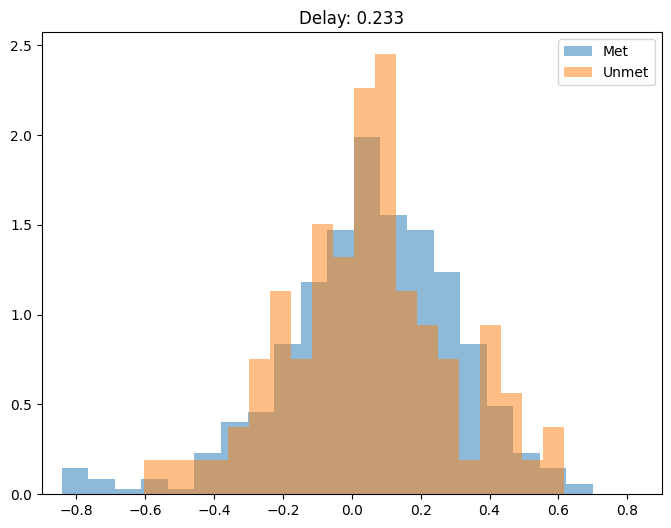

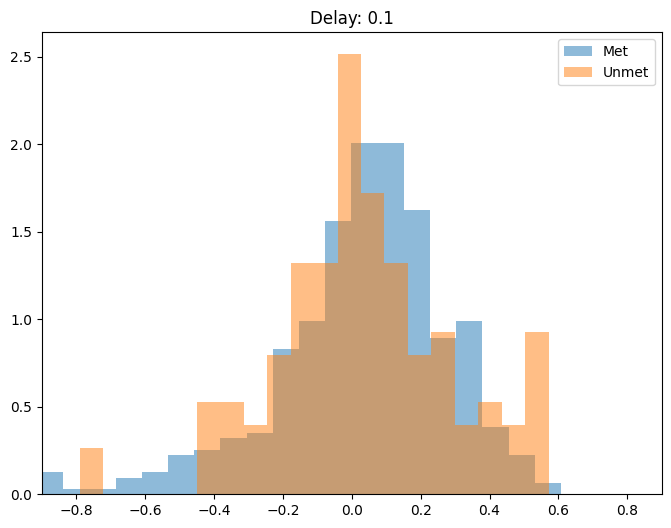

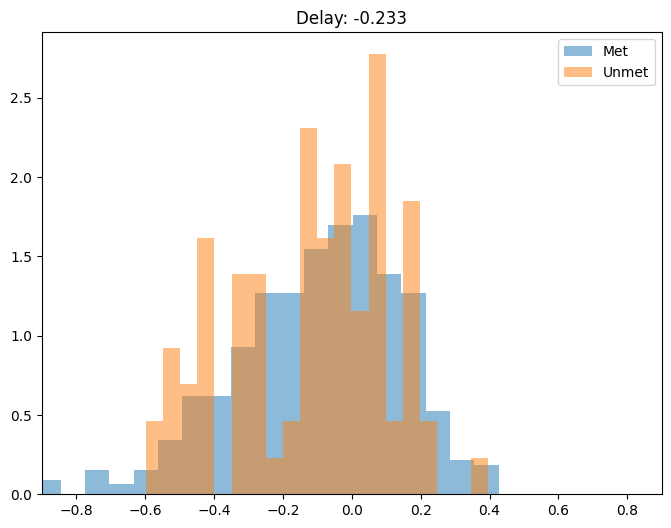

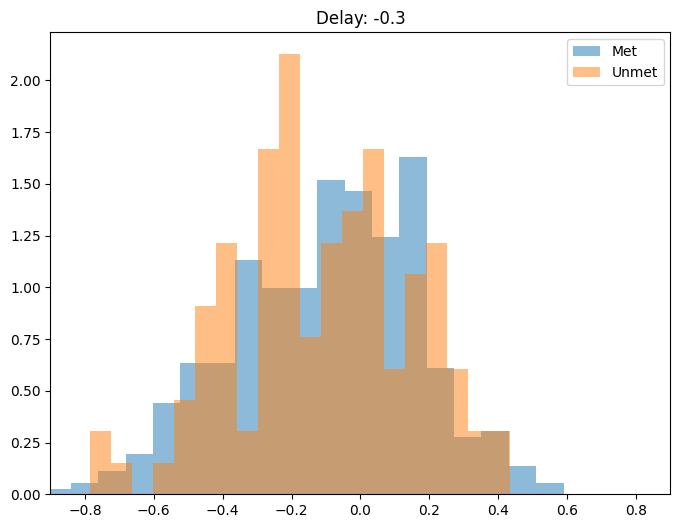

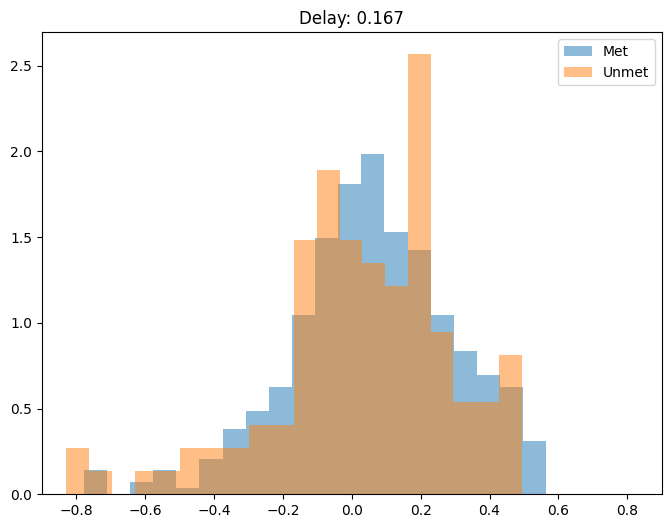

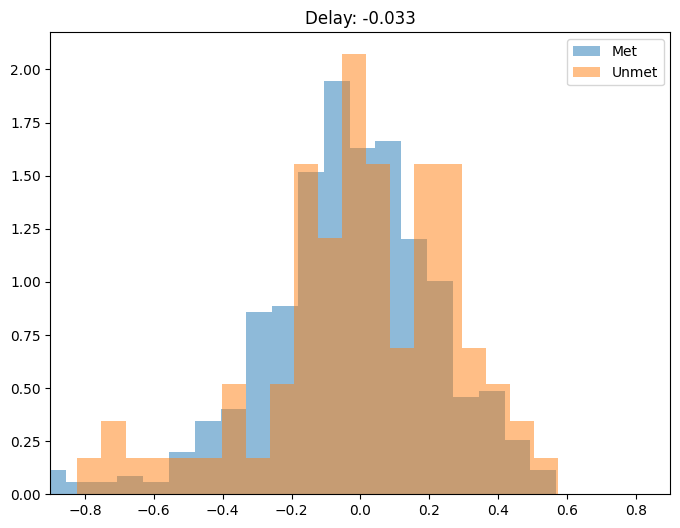

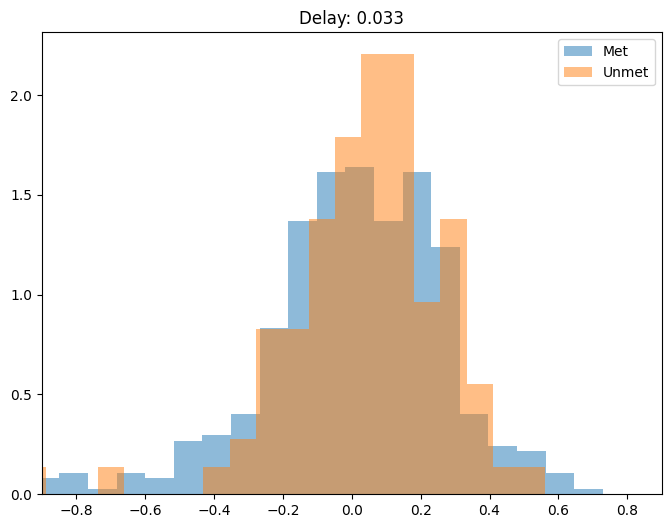

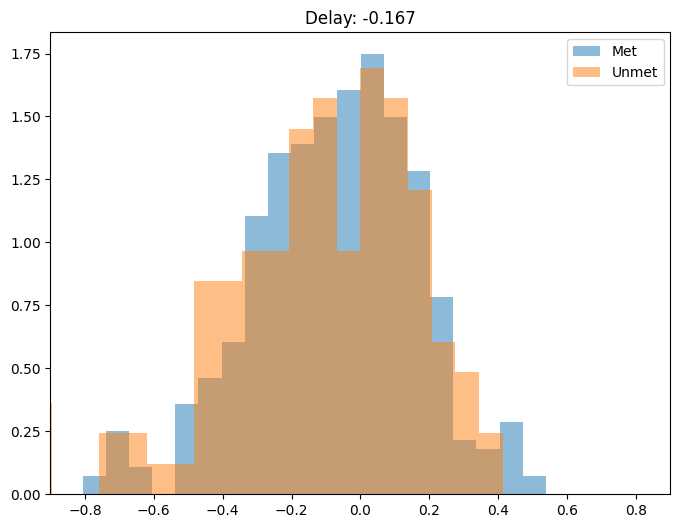

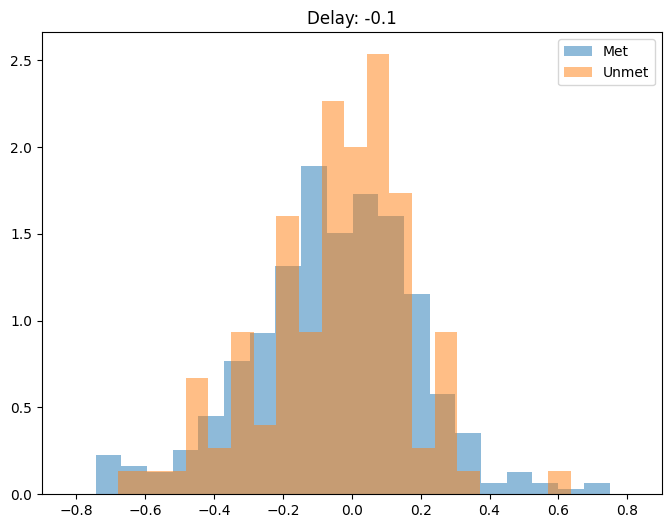

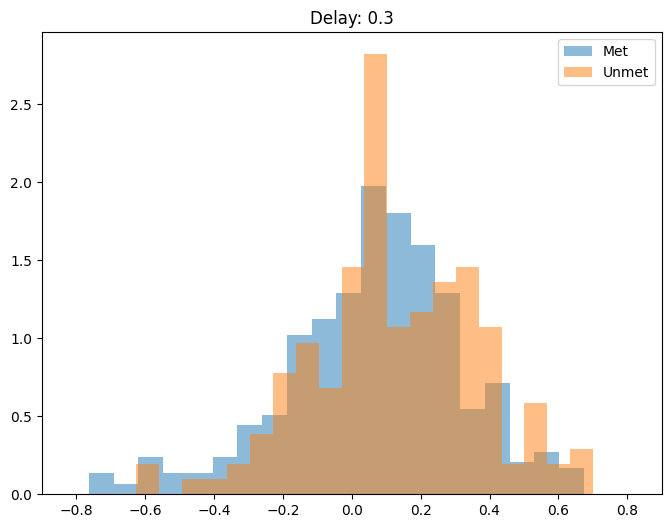

In [ ]:
# PLot histogram density distributions of pTemporalError for each delay for met and unmet conditions in the same plot

for delay in delay_points:

    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    plt.figure(figsize=(8, 6))
    plt.hist(met_data, density=True, bins=20, alpha=0.5, label="Met")
    plt.hist(unmet_data, density=True, bins=20, alpha=0.5, label="Unmet")
    plt.xlim(-0.9,0.9)
    plt.legend()
    plt.title(f"Delay: {delay}")
    plt.show()


In [ ]:
# get descriptive statistics
datas_test_expected.groupby("congruency").describe()["pTemporalErrorFitted"]

,count,mean,std,min,25%,50%,75%,max
congruency,,,,,,,,
met,4361.0,0.003193,0.255999,-0.950997,-0.14626,0.021377,0.176599,0.769490
unmet,1072.0,0.015128,0.259947,-0.901893,-0.13896,0.035336,0.196336,0.689207


In [ ]:
# write the data to a csv file
datas.to_csv("clean_all_data.csv", index=False)

In [ ]:

def model_time_base(delay,alpha,sigma):
	modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
	return modelPerceivedError
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
    return modelPerceivedError
def model_expectation_met(delay,alpha,sigma,delta,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**4)+teta for x in delay]
    return modelPerceivedError
def model_expectation_unmet(delay,alpha,sigma,teta,delta=1):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**5)+teta for x in delay]
    return modelPerceivedError    


### Results

In [191]:
"""
Expectation Shapes Perceived Time of Visual Events
Omer Faruk Yildiran, Pascal Mamassian
École Normale Supérieure






















Introduction
Time perception is a complex and multi-faceted process that remains poorly understood, with a variety of paradigms in need of investigation. This is due to the fact that time perception is not a straightforward process but rather malleable to various factors, and it is subjective in nature. To fully grasp the intricacies of time perception, it is important to remember that subjective perception of time can be obtained through different perceptual modalities, using visual, auditory, or tactile stimuli.
For this reason, one should not think of time perception as an isolated mechanism. There are several factors that can shape our perception of time, including attention, emotion, and expectation. For instance, engaging in an activity that is deemed interesting or enjoyable can cause the time to appear to pass more swiftly in comparison to a tedious or monotonous task (Tse, Intriligator, Rivest & Cavanagh, 2004; Seifried & Ulrich, 2011; Birngruber, Schröter & Ulrich, 2014). Furthermore, emotions can also play a significant role in our perception of time, with individuals in a negative emotional state tending to perceive time as passing more slowly, while those in a positive emotional state perceive time as passing more quickly (Stetson, Fiesta & Eagleman, 2007; Grommet et al., 2011; Gable, Wilhelm & Poole, 2022). When we think about expectation as a way to manipulate attention, it is natural to think that expectation should also play a crucial role in shaping our perception of time; studies have shown that individuals tend to perceive an event as lasting the amount of time they expect it to, regardless of whether it actually lasts longer or shorter (Rhodes & Di Luca, 2016; Matthews & Gheorghiu, 2016; Jones & Botz, 1989). 
In the study of time perception, researchers have primarily employed the measurement of the duration of time intervals as a means of investigation. As early as 1860, Gustav Fechner proposed that the perception of stimuli would be prolonged if presented more frequently. Later studies on duration perception have delved into the ways in which various factors can impact our perception of the duration of events. One key area of focus has been the presence of distractor events. A study by Burr, Rocca and Morrone (2013) found that the presence of a distractor event can significantly alter the perceived duration of a test stimulus. In their experiment, participants were asked to judge the duration of a test interval that was presented between two distractor intervals. The researchers found that short distractors caused the test interval to appear shorter, while longer distractors had the opposite effect. This effect was most pronounced for very short reference durations (≤100ms) and gradually diminished for longer durations, eventually reaching no effect for durations greater than 500ms. Other studies have also reported that distractors can affect the perceived duration of subsequent events, a phenomenon known as the attraction toward the distractor effect (Burr et al., 2013; Sawai, Sato, & Aihara, 2012). The cognitive mechanism underlying this effect is often attributed to a tendency to regularize the sequence of the three consequent event in time that is constituting two attended one irrelevant(‘distractor’) intervals (Shi, Church, & Meck, 2013; Jazayeri & Shadlen, 2010; Hartcher, Di Luca, & Ernst, 2014).
In contrast to the prevalence of studies on duration perception, there are relatively fewer investigations into the perceived time of events. A recent study by Jovanovic and Mamassian (2020) aimed to expand upon previous findings on temporal effects on duration perception by examining the impact on the moment at which an event is perceived. The study revealed that the perceived time of an event is consistently influenced by other events that occur in close temporal proximity. However, the nature of this effect varies depending on the level of attention given to each event.
In their study, participants got familiarized with a specific time interval using a clock whose hand made a single full revolution to indicate the duration of the interval. During the experimental trials, the rotating hand of the clock was removed, and two disks were flashed sequentially during the interval. One of the disks was the target and the other a distractor. At the end of the trial, participants were asked to indicate when they perceived the target by placing the hand of the clock at the location where it would have been if it had been shown during the interval. In separate experiments, which of the two disks was the target was either revealed at the end of the trial, or a cue about its color was given before the trial, or a cue was given about the order of the disks (target presented first or second). The authors found that when the target is unknown during the trial, so participants attended equally to each stimulus, target perception time is attracted by the distractor. On the other hand, when the target is cued by color beforehand, perceived time error increased. This study showed that the moment when a target is perceived is gradually biased by the presentation time of other events if the target event is not known before response phase. However, in the second experiment, when they “pre-cued” the target before the trial, the authors found negative temporal errors, such that participants perceived the target much earlier than their presentation time. This kind of anticipation bias to the distractor in “pre-cued by color” condition gave us the motivation to investigate the perceived moment of events in the context of expectation. 
Examining the relationship between expectation and its impact on perceived time is a relatively novel and under-explored area within psychology and neuroscience. While it has been established that expectation can augment neural processing speed by leveraging prior knowledge for cognitive functions (de Lange, Heilbron, & Kok, 2018; Gau & Noppeney, 2016), the precise mechanisms by which expectation specifically influences our perception of time remains an area that requires further investigation.
Expectation, in general, increases neural processing speed, presumably because our brain is using expectation as prior information. Past studies found that expectations have a significant impact on how humans make perceptual decisions (de Lange et al., 2018; Summerfield & de Lange, 2014). The literature especially shows that in a cued paradigm, the validly expected stimulus is detected or located more quickly and accurately than the unexpected stimulus (Kok, Jehee, & De Lange, 2012). So valid expectations facilitate perceptual choices and shape our perception of noisy stimuli. On the other hand, expectations do not change the system’s internal parameters. The findings indicate that when expectations are not fulfilled, sensory processes are delayed (Urgen & Boyaci, 2019).
Drawing upon the existing literature on expectation, attention, and time perception, our study aims at investigating how expected and unexpected scenarios shape our perception of the occurrence of an event within a given time interval. Our focus will be on the retrospective timing of events, specifically within a very short temporal interval. To achieve this, we will present two independent events in succession and employ a time reproduction task in which participants are asked to estimate the timing of one of these events which will be cued by the color of this stimuli. We hypothesize that when there is an expectation about the upcoming stimulus, this will result in an earlier perception of the onset of the target stimulus in comparison to the actual presentation time. In contrast, for trials in which expectation is unmet, we expect participants to perceive the target stimulus later than the actual presentation time, and the error variability to be greater. More precisely, we suppose that if the target is presented earlier than the distractor, there will be relatively less error compared to a trial where the distractor was presented first. This is because if the target is presented first, we suppose that target time will get attracted towards distractor’s time, but this attraction cannot be enough to eliminate the error or make the error positive. On the other hand, if we ask for the perceived time of an unexpected target, sensory processes will be delayed, participants will be less attentive when the target is shown, and so we expect that they will have a larger temporal error of perceived time. In other words, participants should perceive the stimulus time much later than actual presentation time when the target is unexpected.


Methods
The methods of our study are similar to the ones of the previous research of Jovanovic and Mamassian (2020). We have re-written the experiment in Python PsychoPy and added different expectation conditions. These expectation conditions were such that one specific colour cue being assigned as a target had a higher probability than the other colour cue. Also, we made slight changes about timing stimuli and procedure (see Procedure section for more detail).
Participants
A sample size of 15 people with normal or corrected-to-normal vision was enlisted for the data collection via the RISC mailing list. English language proficiency was required for participants to comprehend the assignment completely. Participants gave their informed consent before the experiment and were provided with a debriefing after the experiment. They received a compensation fee (10 Euros per hour and in total they took ~20 Euros) for participating in the experiment. For the sample size rationale, we made a simulated power analysis using pilot data with Linear Mixed Model analysis. We obtained a 0.36 effect size for the delay between distractor and target and .80 power for 15 participants.
The power analysis revealed that a sample size of 5 participants yielded a power of 22%, while increasing the sample size to 10, 15, and 20 participants resulted in powers of 62%, 81%, and 91% respectively. These power calculations were based on a 95% confidence interval and accounted for the largest number of participant. The sample sizes determined through power analysis allowed us to achieve sufficient statistical power to detect meaningful effects and draw reliable conclusions from our data.
Stimuli
As stimuli, we used two stationary disks, which were flashed in the center of the screen one after the other. These disks were either green or red with a diameter of 2 deg of visual angle (dva). As a task, at the end of each trial, participants are asked to report the onset time of one of these disks. For this reason, in each trial, one of the disks (red or green) is randomly assigned as target stimulus and the other as distractor stimulus.
To reference one revolution of time-interval, participants were shown a clock, whose hand made a full revolution (360 degrees) in 2 seconds (Figure 1). The clock had only one hand, and this hand only appeared during the familiarization phase. During the actual experimental trials, the outer ring of the clock stayed, and in the response phase, a time indicator was presented to the participants that they had to place on the rim of the clock to indicate their estimated target time. 
 
There was a blank circle with a white border positioned in the center of the screen. This circle had the same diameter as the stimuli and served as a placeholder in the absence of stimuli. We also used a 33-ms auditory cue at the beginning and end of each trial to give extra information about the time-interval by deliberately indicating the start and end of each trial interval. Between the trials, on a blank gray screen, there was only a black cross symbol in the center that was used as a fixation point.

Procedure
At the beginning of the experiment, there was a familiarization phase consisting of 20 revolutions of the clock’s hand movement for 2 seconds. The familiarization phase was also shown before each new block with 4 loops.
After the fixation point, every trial started with an auditory cue, and the placeholder and the ring of the clock became visible (Figure 2). Then there was a variable duration until the onset of the first stimuli, which would later be defined as either target or Distractor. It stayed on screen for 33ms, it could be red or green, but for simplicity in description, let us say it is red for now. In close temporal proximity, in predefined 10 levels between -300ms, and +300ms, the other stimulus appeared (green) for 33-ms. Then the placeholder replaced the last stimulus, until the end of the trial when an auditory cue was presented, and the placeholder was replaced by the fixation point.
At the end of the trial, in the center of the screen, a cue circle (red/green) was shown to inform the participant which stimulus was the Target, the other color being de facto the Distractor.
After the participants were informed which color was the target, the time indicator was presented at a random initial position on the ring. Participants were asked to move the cursor to indicate the perceived moment using a left-click of the mouse, and until releasing their finger, they had still a chance to change their answer by moving the mouse.
Each participant initially had a training with single stimulus (i.e., no distractor) in which they also received feedback about the correct timing of stimuli. This feedback was shown on the circle with a color of its own. Then similarly to the single stimulus training session, participants performed a baseline condition in which there was no distractor stimulus presented, and they had to estimate the onset time of that single stimulus. For this baseline condition, there were 40 trials with no feedback. Subsequently, there was a training session with two stimuli (target and distractor discs) for 40 trials without any feedback. This training part was the same as the actual experiment but with relatively easier trials since the delay between distractor and target was fixed to either -500ms or +500ms. 
After these training and baseline sessions, the actual test trials began. The experiment was be divided into two conditions that we will call “expectation condition” and “no-expectation condition” (Figure 3). Each experimental condition was blocked and took approximately 1 hour, with 500 trials for each condition. Each trial lasted approximately 4s (2s trial time-interval, ~1s response duration, 1s inter trial interval) and there were 20 blocks (with a small break every 25 trials) for each condition. The order of experimental conditions was counterbalanced between participants. In the no-expectation condition, the probability of the target (time of onset of a disk) was equal for each color. In the expectation condition, 80% of the trials were such that the target was of one particular color. Presentation of chosen color cue in the expectation condition (red/green) was also counterbalanced between participants. Before the expectation condition, participants were informed that the probability of the target was higher for one of the colors, but we did not tell which color was more common.
Results
1. Baseline Condition: Single stimuli condition
To establish the relationship between perceived time and actual time on the single stimulus trials, we employed a sinusoidal model to fit the data so as to generate corrected versions of the target and distractor time for each trial in the actual experimental trials. This correction was necessary to account for the non-linear relationship between perceived time and actual time. The plot depicting perceived time against actual time for the single stimulus trials revealed a systematic bias in participants’ judgments (see Figure 4). Specifically, participants tended to be biased near the beginning and the end of the 2-second interval. It became evident that this bias needed to be addressed to accurately analyze the temporal errors in the experimental trials. By applying the correction to the actual target and distractor times, we aimed to eliminate this bias and obtain more precise measurements of temporal errors.
	No-Expectation Condition: Effect of time between stimuli
To replicate the original study, we first ran the experiment without implicit priming of the participants. In this experiment, the participants were asked to report the time of one of the stimuli, and the probability of this target stimulus was 0.5 to be of a particular colour. Here we wanted to replicate the results of the effect of the delay between distractor and target on the perceived moment of the target. 
We calculated the temporal error as the difference between the reported (estimated) and actual (physical) presentation timings to determine the accuracy of the target’s perceived time. At first, we made a simple Linear Mixed Model (LMM) with the temporal error as the dependent variable, and delay between distractor and target as the fixed effect, and we used participants as the random effect. LMM revealed a significant effect of delay (in seconds) on perceived time errors of the targets in the No-expectation condition. The estimated coefficient for the delay was 0.310 (SE = 0.015, t = 20.5, p < .001), indicating a highly significant effect. This means that as delay increases, participants had larger Perceived Time Errors. More precisely, if the distractor was presented earlier than the target, participants reported the target earlier than it actually was, and if the distractor was presented after the target, participants reported the target later than it was. This is in line with the results of the original study. These results are clearly visible in Figure 5, where the temporal error is plotted against the delay between distractor and target stimuli. To fit the temporal errors, we tried different functions and decided to use a derivative of Gaussian applied to the delay between distractor and target. This function has the following equation for the temporal error:
TemporalError=f(x)=t_t^'-t_t=α⋅((t_d-t_t ))/σ⋅exp⁡[-(t_d-t_t )^2/σ^2 ]
In this equation, α represents the error constant which handles the height of the fit, t_t denotes the actual target onset time, t_t^' represents the perceived target onset time, t_d represents the actual distractor onset time, and σ is the parameter that controls the width of the fit. Using this model, we further investigated the effect of delay on perceived time error. We used delay and the interaction between delay and “derivative of Gaussian function of delay” as fixed effects and participants as random effects. 

The analysis results showed that delay had a significant effect on Temporal Error (β = 0.310, SE = 0.0151, t = 20.5, p < .0001). Moreover, the shape of the delay distribution, as captured by the derivative Gaussian function, significantly affected Temporal Error in a positive way (β = 0.196, SE = 0.094, t = 2.08, p = 0.0371). These results suggest that both the magnitude of the Distractor-Target Delay and the shape of the delay distribution play important roles in influencing individuals’ perception of time. 
	When there is an expectation towards a certain colour
In the second condition of the experiment, we aimed to investigate the effects of inducing prior cues towards a certain colour on perceived time. Based on previous findings on prior entry effects, we initially predicted that in expected trials (i.e., when the expectation is met), participants would perceive the stimuli as occurring earlier than the actual presentation time. However, contrary to our initial prediction, the results showed a similar trend in expected trials as in the no-expectation condition (Figure 6). Interestingly, when comparing trials where the expectation was met versus unmet, we observed that participants perceived the target later in unmet trials when the target is presented before the distractor (right hand side of the plot). Reversely, when the distractor is presented before the target (left hand side of the plot), participants perceive the target earlier in the unmet trials than the met trials. To analyze these findings, we employed the same LMM as the one we used in the no-expectation condition, but this time we needed to add a congruency (expectation met/unmet) factor to the model so as to also investigate the effect of expectation congruency. 
The LMM revealed that delay had a significant effect on perceived temporal error (β = 0.3048, SE = 0.0176, t = 17.332, p < 0.001), indicating that an increase in the delay between distractor and target stimuli was associated with a greater temporal error. The shape of the delay distribution showed a non-significant effect on perceived temporal error (β = 0.1475, SE = 0.109, t = 1.352, p = 0.1763). When considering the congruency of the expectation (expectation met vs. unmet), we found a significant interaction between delay and congruency on perceived temporal error (β = 0.07857, SE = 0.03877, t = 2.027, p = 0.0427), indicating that the effect of the delay on temporal error differed between expectation met and unmet trials. These results suggest that inducing prior cues towards a certain colour did not significantly alter the pattern of perceived temporal error. However, when the expectation was unmet, the target is more biased by the distractor. The significant interaction between delay and congruency indicates that the effect of the distractor-target delay on temporal error differs depending on whether the expectation was met or unmet. In Figure 7, we plotted the temporal error against the delay between the distractor and target stimuli for the expectation met and unmet trials. One can see that the temporal error is higher in the unmet expectation trials compared to the met expectation trials.
Upon visual inspection, it is evident that the model fits the data more accurately for the met expectation condition. However, one must remember that, by definition, there are four times fewer unmet trials than met trials. When comparing the met and unmet expectation conditions, an interesting pattern emerges. In the unmet trials, where the distractor is presented before the target, participants exhibited an even greater bias in perceiving the onset time of the target. This bias resulted in larger negative temporal errors, indicating that participants perceived the target time even earlier than its actual occurrence, as compared to the met trials.This observation suggests that participants may perceive the distractor as the target due to its colour as they were primed for that colour to be the target. So when participants need to report the perceived time, they are affected by the time of the stimulus that captured more their attention (the distractor). In contrast, when the distractor is presented later than target, the magnitude of increase in temporal error is higher than in met trials. 

	Detailed investigation on each of the delay bins
In order to gain a deeper understanding of the relationship between perceived time and different delay conditions, a more detailed investigation was conducted. Density distributions were plotted for each delay bin, representing the met and unmet trials (Figure 7). This analysis aimed to uncover any potential differences in perceived time between the two conditions. The density plots provided a visual representation of the distribution of perceived time for each delay bin. The plots did not reveal any obvious distinct patterns. To quantify the results, a series of independent t-tests were conducted to compare the means of perceived time between these conditions at each delay point. The results are summarized as follows: 
There were no statistically significant differences in perceived temporal error between the met and unmet trials at most delay points. However, a significant difference was observed at a delay of 0.3s, where the mean perceived time for the met tirals (0.076s) was significantly lower than that for the unmet trials (0.132 s).

	 Response Time and Reaction Times
Response time and reaction time were examined separately as distinct measures in our experiment. Reaction time was defined as the duration between the beginning of the response phase and the participant’s initiation of a movement, indicated by the movement of the mouse. The response phase began when the trial ended, and the response pointer and cue appeared on the screen. The reaction time was recorded when the participant started moving the mouse and reached a minimum movement threshold of at least 1 degree of visual angle, indicating that the participant moved the mouse away from the center of the cue disk and the response pointer began to move. On the other hand, response time was measured as the time that elapsed between the participant’s reaction time and their final response that they gave by the mouse click-release. This measure provided insights into the time taken from the participant’s initial movement to their final response. 
To investigate the effect of expectation on these measures, we conducted t-tests to compare the reaction times and response times between expectation-met and unmet trials. The results of the t-test revealed that there was no significant difference in reaction times between the expectation-met and unmet trials. However, a significant difference was found in response times between these trials. The t-statistic was -2.54, with a p-value of 0.011, suggesting that the mean response times differed significantly between the expectation met and unmet trials.
Further examination of the response time data revealed that the median response time for the expectation-met trials was 0.975 seconds, while for the expectation-unmet trials, it was 1.017 seconds. This difference in response times suggests that participants took slightly longer to respond in the unmet trials compared to the met trials (Figure 8).
To visually depict our findings, we created density plots for both reaction times and response times. Figure 7 illustrates the density distributions of the response times, revealing a slightly higher distribution of response times in the expectation unmet trials compared to the expectation met trials. Additionally, we used an ex-Gaussian fit to model the reaction times. This distribution allowed us to explore the underlying components of the reaction time data, taking into account both normal and exponential components (Hohle, 1965). These findings highlight the influence of expectation on response times and suggest that the participants’ anticipation of the upcoming event had an impact on their decisive processes, and this led to differences in response times.

Discussion
This study aimed to investigate the effects of distractor and expectation on perceived temporal errors of a briefly presented target. The results yield valuable insights into the factors influencing individuals' perception of time and shed light on the role of expectation in temporal processing.
In the No-Expectation Condition, we successfully replicated the findings of the original study of Jovanovic & Mamassian (2020), demonstrating a significant effect of the delay between distractor and target stimuli on perceived time of the target. Consistent with previous research, our findings indicate that deviations from zero delay led to increased perceived time errors, both when the distractor preceded and followed the target. When the distractor was presented before the target, participants tended to report the target as occurring earlier than it actually did, and vice versa. This phenomenon is commonly referred to as the attraction-towards distractor effect (Burr et al., 2013; Sawai, Sato, & Aihara, 2012).
Furthermore, the analysis confirmed that both the delay and the shape of the delay distribution impact perceived time of events. The effect of delay is not just linear; instead, it diminishes for large delays, and presumably vanishes when the distractor is temporally very far from the target.
The second condition of the experiment focused on examining the effects of inducing expectation through priming towards a specific color on perceived time. Contrary to our initial prediction, the results did not support the hypothesis that participants would perceive stimuli as occurring earlier when they had an expectation towards a specific color. Instead, we observed a very similar trend in expected trials as in the no-expectation condition. These results contradict previous literature that suggests the prior-entry effect, which posits that attended events are perceived earlier (Titchener, 1980), and they are in apparent conflict with the findings of a previous experiment by Jovanovic and Mamassian (2020) that utilized the same procedure and stimuli, but with an explicit pre-cueing of the target before the trial. It is possible that these differences result from the presentation of an implicit cue (as we did here by manipulating the probability of occurrence of a certain colour), or the validity of the cue (we used an 80% validity whereas it was 100% in Jovanovic & Mamassian, 2020).
Interestingly, when comparing trials where the expectation was met versus unmet, we found that participants perceived the target stimuli as occurring later in unmet trials compared to met trials, where the target was presented before the distractor. This observation aligns with previous literature suggesting that unmet expectations can delay sensory processes (Urgen & Boyaci, 2019; Kok, Jehee, & De Lange, 2012).
These findings suggest that manipulating the expectation towards a specific color did not significantly alter the pattern of perceived temporal errors. However, an interaction effect was observed, indicating that for a specific delay (0.3s, p=.011), perceived errors were higher for the unmet expectation condition. Although this effect was not statistically significant, it suggests that when the expectation was unmet and the distractor was displayed first, participants exhibited a tendency to perceive the target stimuli as occurring before, and vice versa when the distractor was displayed later than the target. This highlights the influence of unmet expectations on temporal judgments and suggests that participants' attention may be more influenced by stimuli that capture their attention, such as distractors.
Additionally, the analysis of response times provided further insights into the influence of expectations on participants' performance. Although there was no significant difference in reaction times between expectation-met and unmet trials, the analysis revealed a significant difference in response times. Participants took slightly longer to respond in the unmet trials compared to the met trials. This finding suggests that participants' anticipation of an upcoming event had an impact on their decision-making processes, leading to slightly delayed responses in unmet expectation trials.
In summary, the study confirms the effect of other temporal events (delays) on time perception. Additionally, a slight difference between expected and unexpected trials was found. The limited disparity between the met and unmet conditions may be attributed to our linear conceptualization of time, unaffected by expectation. To address this limitation in future research, it may be necessary to explore the nonlinear nature of perceived time response. Furthermore, in the "expectation" condition, our aim was to prompt participants to predict the target stimulus by manipulating the color ratio of both the target and distractor stimuli. This manipulation was intended to create an expectation regarding the timing of the target stimulus indirectly. However, while our intention was to prime about the "time" of target, it is possible that participants developed an expectation, just based on the "color" aspect. Consequently, the stimulus they anticipated might not have influenced their perception about target onset time of the target time, even though it led to deformations and larger biases on unexpected trials. 
In conclusion, these findings provide valuable insights into how expectations shape our perception of the timing of environmental stimuli and how they are influenced by temporally proximate stimuli. However, it is important to note that this study only investigates perceived moment relative to other events. Further research should be conducted to examine the effect of expectation on the absolute timing of exclusive events, independent of other events.

Acknowledgements
Thanks very much to Ljubica Jovanovic for providing detailed explanations on their method,  and precious comments on analysis.
Supplementary material
All of the data analysis procedures and experiment code can be found in 

References:
Angrilli, A., Cherubini, P., Pavese, A., & Manfredini, S. (1997). The influence of affective factors on time perception. Perception & Psychophysics, 59(6), 972–982. https://doi.org/10.3758/BF03205512
Birngruber, T., Schröter, H., & Ulrich, R. (2014). Duration perception of visual and auditory oddball stimuli: Does judgment task modulate the temporal oddball effect? Attention, Perception, & Psychophysics, 76(3), 814–828. https://doi.org/10.3758/s13414-013-0602-2
Brown, S. W., & Boltz, M. (2002). Attentional processes in time perception: Effects of mental workload and event structure. Journal of Experimental Psychology: Human Perception & Performance, 28, 600-615. doi:10.1037/0096-1523.28.3.600
Burr, D., Rocca, E. D., & Morrone, M. C. (2013). Contextual effects in interval-duration judgements in vision, audition and touch. Experimental brain research, 230(1), 87-98.
De Lange, F. P., Heilbron, M., & Kok, P. (2018). How do expectations shape perception?. Trends in cognitive sciences, 22(9), 764-779.
Fechner, G. T. (1860). Elemente der psychophysik (Vol. 2). Breitkopf u. Härtel.
Gau, R., & Noppeney, U. (2016). How prior expectations shape multisensory perception. Neuroimage, 124, 876-886.
Grommet, E. K., Droit-Volet, S., Gil, S., Hemmes, N. S., A. Baker, H., and Brown, B. L. (2011) Time estimation of fear cues in human observers. Behavioural Processes, 86(1) 88-93.
Grondin, S. (2010). Timing and time perception: A review of recent behavioral and neuroscience findings and theoretical directions. Attention, Perception, & Psychophysics, 72(3), 561–582. https://doi.org/10.3758/APP.72.3.561
Hartcher-O’Brien, J., Di Luca, M., & Ernst, M. O. (2014). The duration of uncertain times: audiovisual information about intervals is integrated in a statistically optimal fashion. PloS one, 9(3), e89339.
Herbst, S. K., Javadi, A. H., van der Meer, E., & Busch, N. A. (2013). How Long Depends on How Fast—Perceived Flicker Dilates Subjective Duration. PLoS ONE, 8(10), e76074. https://doi.org/10.1371/journal.pone.0076074
Hohle, R. H. (1965). Inferred components of reaction times as functions of foreperiod duration. Journal of experimental psychology, 69(4), 382.
Jansson, C., Marlow, N., & Bristow, M. (2004). The influence of colour on visual search times in cluttered environments. Journal of Marketing Communications, 10(3), 183–193. https://doi.org/10.1080/1352726042000207162
Jazayeri, M., & Shadlen, M. N. (2010). Temporal context calibrates interval timing. Nature neuroscience, 13(8), 1020-1026.
Jones, M. R., & Boltz, M. (1989). Dynamic attending and responses to time. Psychological Review, 96, 459-491. doi:10.1037/0033-295X .96.3.459
Jovanovic, L., & Mamassian, P. (2020). Temporal context affects the perceived time of visual events. Psychonomic Bulletin & Review, 27(1), 56-61.
Kok, P., Jehee, J. F., & De Lange, F. P. (2012). Less is more: expectation sharpens representations in the primary visual cortex. Neuron, 75(2), 265-270.
Matthews, W. J., & Gheorghiu, A. I. (2016). Repetition, expectation, and the perception of time. Current Opinion in Behavioral Sciences, 8, 110-116.
Rhodes, D., & Di Luca, M. (2016). Temporal Regularity of the Environment Drives Time Perception. PLOS ONE, 11(7), e0159842. https://doi.org/10.1371/journal.pone.0159842
Sawai, K. I., Sato, Y., & Aihara, K. (2012). Auditory time-interval perception as causal inference on sound sources. Frontiers in psychology, 3, 524.
Seifried, T., & Ulrich, R. (2011a). Exogenous visual attention prolongs perceived duration. Attention, Perception, & Psychophysics, 73(1), 68–85. https://doi.org/10.3758/s13414-010-0005-6
Shi, Z., Church, R. M., & Meck, W. H. (2013). Bayesian optimization of time perception. Trends in cognitive sciences, 17(11), 556-564.
Stetson, C., Fiesta, M. P., and Eagleman, D. M. (2007). Does time really slow down during a frightening event? PLoS One 2:e1295. doi: 10.1371/journal.pone. 0001295
Summerfield, C., & De Lange, F. P. (2014). Expectation in perceptual decision making: Neural and computational mechanisms. Nature Reviews Neuroscience, 15(11), 745.
Treisman, M., Faulkner, A., Naish, P. L. N., & Brogan, D. (1990). The Internal Clock: Evidence for a Temporal Oscillator Underlying Time Perception with Some Estimates of its Characteristic Frequency. Perception, 19(6), 705–742. https://doi.org/10.1068/p190705
Tse, P. U., Intriligator, J., Rivest, J., & Cavanagh, P. (2004). Attention and the subjective expansion of time. Perception & Psychophysics, 66(7), 1171–1189. https://doi.org/10.3758/BF03196844
Urgen, B. M., & Boyaci, H. (2019). When expectations are not met: unraveling the computational mechanisms underlying the effect of expectation on perceptual thresholds. BioRxiv, 545244.


"""




'\nExpectation Shapes Perceived Time of Visual Events\nOmer Faruk Yildiran, Pascal Mamassian\nÉcole Normale Supérieure\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIntroduction\nTime perception is a complex and multi-faceted process that remains poorly understood, with a variety of paradigms in need of investigation. This is due to the fact that time perception is not a straightforward process but rather malleable to various factors, and it is subjective in nature. To fully grasp the intricacies of time perception, it is important to remember that subjective perception of time can be obtained through different perceptual modalities, using visual, auditory, or tactile stimuli.\nFor this reason, one should not think of time perception as an isolated mechanism. There are several factors that can shape our perception of time, including attention, emotion, and expectation. For instance, engaging in an activity that is deemed interesting or enjoyable can cause the time to appear to pass more

In [ ]:
"""
#Create the abstract of article based on given informations
Abstract
Effect of expectation on time perception
Time perception is a fundamental cognitive process that allows us to perceive and interact with the world in real time. 
But it is not a passive process, rather an active process that is influenced by many factors. One of the factors that can affect the perception of time is the expectation.
 of the individuals.
In this study we aimed to investigate the effect of expectation on time perception. For this purpose, we conducted a literature review and examined the studies that investigated the effect of expectation on time perception. In the light of the findings obtained, it was concluded that expectation has an effect on time perception. In addition, it was concluded that the effect of expectation on time perception is related to the type of 
strength of expectation, the delay between two events. 

In time perception, when there is two consecutive events, which one is target and one of them is distractor, how do we call this situation?
C


"""